# House Price Prediction - Machine Learning Model

In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.datasets import fetch_california_housing
import warnings
warnings.filterwarnings('ignore')


In [2]:
# Set up styling for visualizations
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("coolwarm")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 14

 # House Price Prediction
 
 ## Introduction
 
 This notebook demonstrates the development of machine learning models to predict house prices using the California Housing dataset. We'll go through the following steps:
 
 1. Data Preprocessing
 2. Exploratory Data Analysis
 3. Feature Engineering
 4. Model Development
 5. Model Evaluation
 6. Conclusion

 ## 1. Data Preprocessing
### 1.1 Load the Dataset
 
 We'll use the California Housing dataset which is available in scikit-learn. This dataset contains information about housing in various block groups in California based on the 1990 census data.

In [3]:
# Load California Housing dataset
california_housing = fetch_california_housing()
X = pd.DataFrame(california_housing.data, columns=california_housing.feature_names)
y = pd.Series(california_housing.target, name='MedianHouseValue')

In [4]:
# Display dataset info
print(f"Dataset shape: {X.shape}")
print(f"Target variable shape: {y.shape}")
print("\nFeature names:")
for i, feature in enumerate(california_housing.feature_names):
    print(f"{i+1}. {feature}")
print(f"\nTarget variable: {y.name}")

Dataset shape: (20640, 8)
Target variable shape: (20640,)

Feature names:
1. MedInc
2. HouseAge
3. AveRooms
4. AveBedrms
5. Population
6. AveOccup
7. Latitude
8. Longitude

Target variable: MedianHouseValue


In [5]:
# Display first few rows of the dataset
print("\nPreview of the dataset:")
pd.concat([X, y], axis=1).head()


Preview of the dataset:


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedianHouseValue
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422



 ### 1.2 Check for Missing Values and Data Quality


In [6]:
# Check for missing values
missing_values = X.isnull().sum()
print("Missing values per column:")
for col, count in zip(missing_values.index, missing_values.values):
    print(f"{col}: {count}")

# Basic statistics for numerical features
print("\nBasic statistics for features:")
X.describe()

Missing values per column:
MedInc: 0
HouseAge: 0
AveRooms: 0
AveBedrms: 0
Population: 0
AveOccup: 0
Latitude: 0
Longitude: 0

Basic statistics for features:


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
count,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,3.870671,28.639486,5.429000,1.096675,1425.476744,3.070655,35.631861,-119.569704
std,1.899822,12.585558,2.474173,0.473911,1132.462122,10.386050,2.135952,2.003532
min,0.499900,1.000000,0.846154,0.333333,3.000000,0.692308,32.540000,-124.350000
25%,2.563400,18.000000,4.440716,1.006079,787.000000,2.429741,33.930000,-121.800000
50%,3.534800,29.000000,5.229129,1.048780,1166.000000,2.818116,34.260000,-118.490000
75%,4.743250,37.000000,6.052381,1.099526,1725.000000,3.282261,37.710000,-118.010000
max,15.000100,52.000000,141.909091,34.066667,35682.000000,1243.333333,41.950000,-114.310000


### 1.3 Data Cleaning and Preparation
 
 The California Housing dataset is already clean with no missing values. However, we'll still set up a preprocessing pipeline that can handle missing values in case they occur in future data.

In [15]:
# Define numerical and categorical features
numerical_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X.select_dtypes(include=['object', 'category']).columns.tolist()

print(f"Numerical features: {numerical_features}")
print(f"Categorical features: {categorical_features}")

# Define preprocessing pipelines
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Create preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features)
    ]
)

Numerical features: ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude']
Categorical features: []


## 2. Exploratory Data Analysis (EDA)
 
 Let's explore the dataset to understand the distributions and relationships between features.
### 2.1 Distribution of Target Variable

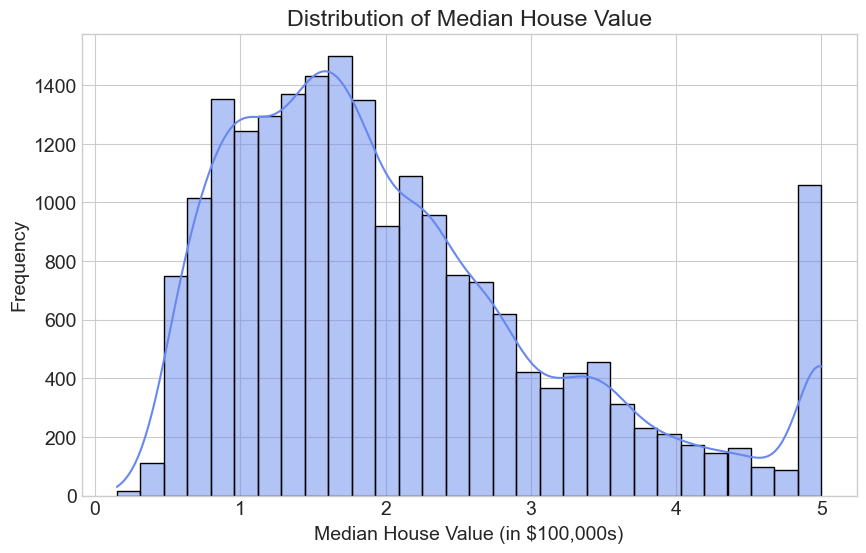

In [16]:
# Plot the distribution of the target variable
plt.figure(figsize=(10, 6))
sns.histplot(y, kde=True, bins=30)
plt.title('Distribution of Median House Value')
plt.xlabel('Median House Value (in $100,000s)')
plt.ylabel('Frequency')
plt.show()

### 2.2 Correlation Analysis

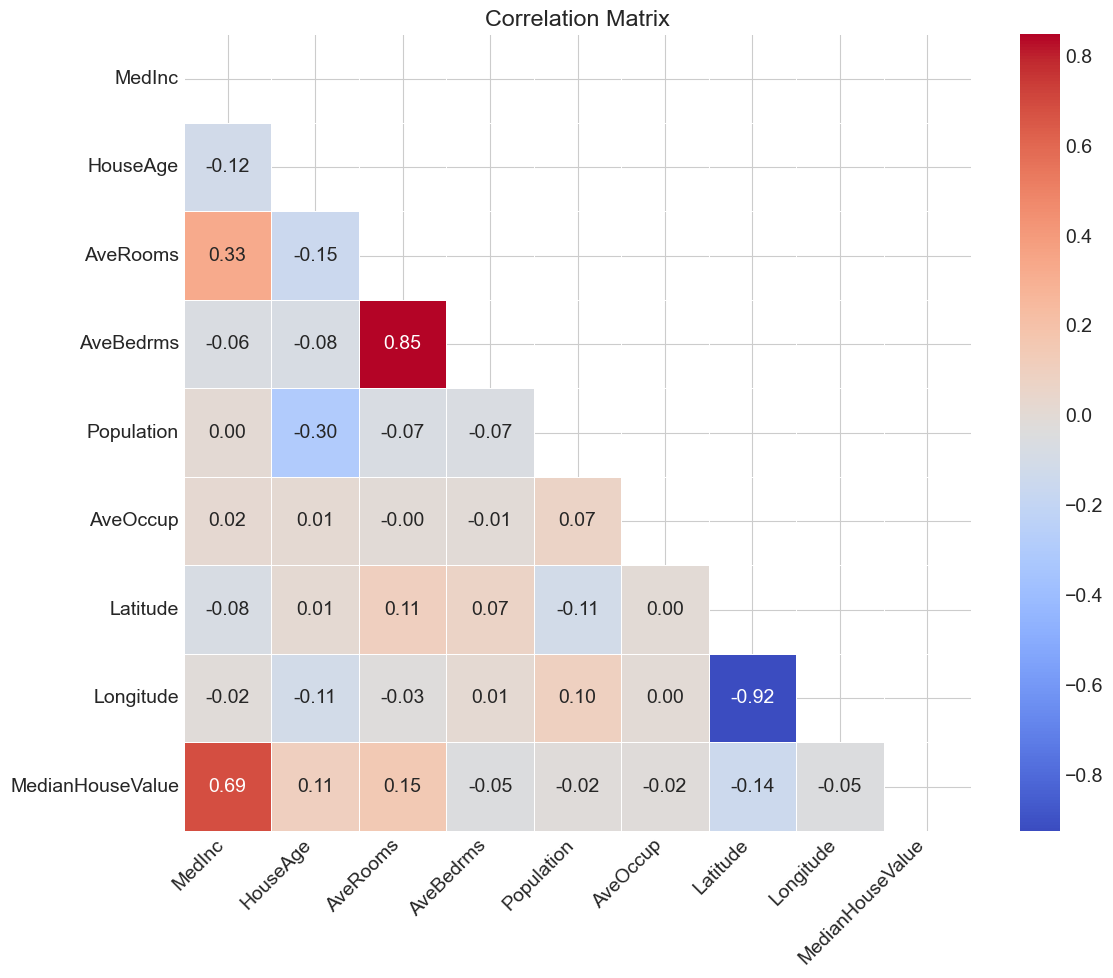

In [17]:
# Create a correlation heatmap
corr_matrix = pd.concat([X, y], axis=1).corr()
plt.figure(figsize=(12, 10))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, mask=mask, cmap='coolwarm', annot=True, fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

### 2.3 Feature-Target Relationships

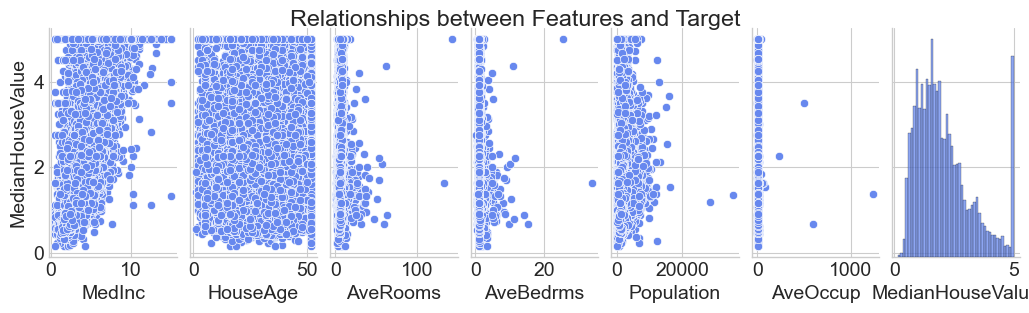

In [34]:
# Create pairplots for key features and target
selected_features = ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup']
pairplot_data = pd.concat([X[selected_features], y], axis=1)
sns.pairplot(pairplot_data, y_vars=['MedianHouseValue'], height=3, aspect=0.5)
plt.suptitle('Relationships between Features and Target', y=1.02)
plt.show()

### 2.4 Geographical Distribution of House Prices

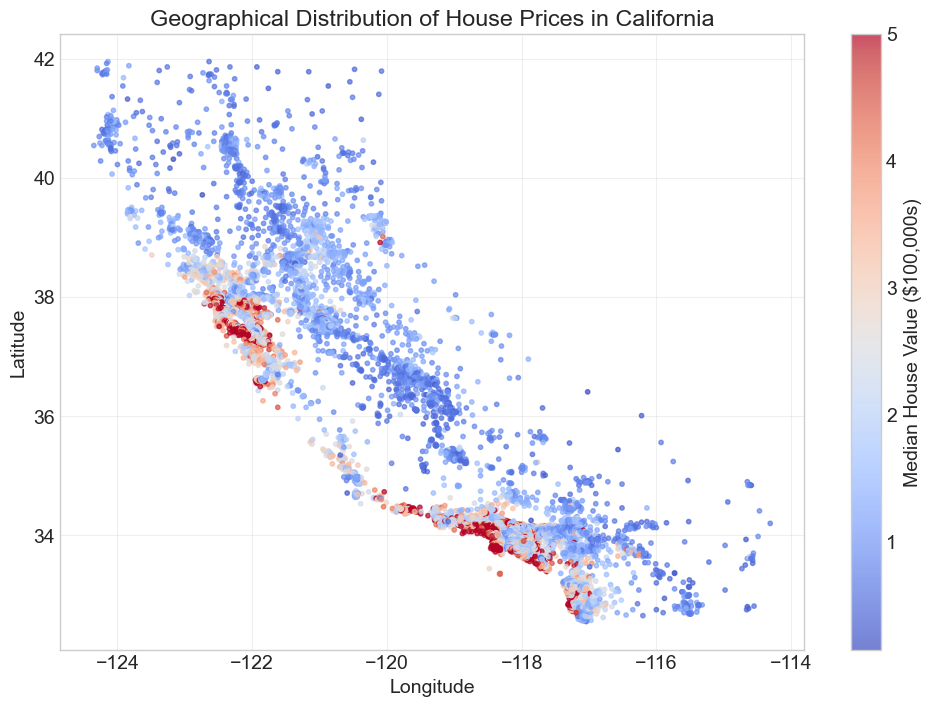

In [19]:
# Create a scatter plot showing geographical distribution of prices
plt.figure(figsize=(12, 8))
scatter = plt.scatter(X['Longitude'], X['Latitude'], 
                      c=y, cmap='coolwarm', s=10, alpha=0.7)
plt.colorbar(scatter, label='Median House Value ($100,000s)')
plt.title('Geographical Distribution of House Prices in California')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True, alpha=0.3)
plt.show()


## 3. Feature Engineering
 
Based on our EDA, let's create some new features that might help improve our model.

In [20]:
# Create a copy of the original dataset
X_engineered = X.copy()

# Feature 1: Rooms per household (density measure)
X_engineered['RoomsPerHousehold'] = X['AveRooms'] / X['AveOccup']

# Feature 2: Bedrooms ratio (proportion of bedrooms)
X_engineered['BedroomRatio'] = X['AveBedrms'] / X['AveRooms']

# Feature 3: Population density
X_engineered['PopulationDensity'] = X['Population'] / X['AveOccup']

# Log transform of income (since it showed a skewed distribution)
X_engineered['LogMedInc'] = np.log1p(X['MedInc'])

# Display the engineered features
print("Engineered features added:")
for col in X_engineered.columns[len(X.columns):]:
    print(f"- {col}")

# Check correlation of new features with target
new_features_corr = pd.concat([X_engineered, y], axis=1).corr().loc[X_engineered.columns[len(X.columns):], 'MedianHouseValue']
print("\nCorrelation with target:")
print(new_features_corr)

Engineered features added:
- RoomsPerHousehold
- BedroomRatio
- PopulationDensity
- LogMedInc

Correlation with target:
RoomsPerHousehold    0.209482
BedroomRatio        -0.255624
PopulationDensity    0.065843
LogMedInc            0.669914
Name: MedianHouseValue, dtype: float64



## 4. Model Development
 
 Now, let's build and compare different regression models:
 1. Linear Regression (baseline)
 2. Random Forest Regressor
 3. Gradient Boosting Regressor

### 4.1 Data Splitting

In [21]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X_engineered, y, test_size=0.2, random_state=42
)

print(f"Training set: {X_train.shape}")
print(f"Testing set: {X_test.shape}")

# Update feature lists to include engineered features
all_numerical_features = X_engineered.columns.tolist()

# Update the preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, all_numerical_features)
    ]
)

Training set: (16512, 12)
Testing set: (4128, 12)



### 4.2 Model 1: Linear Regression (Baseline)



Linear Regression Performance:
RMSE: 0.6732
MAE: 0.4887
R²: 0.6541


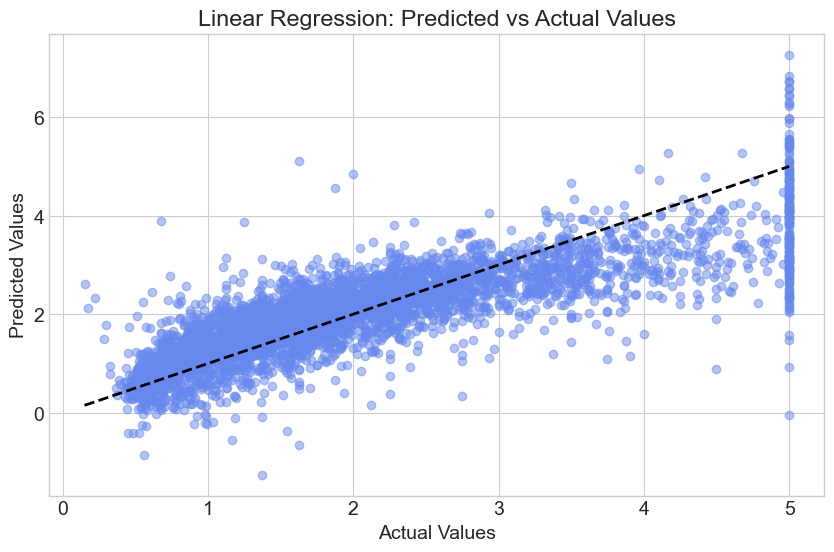

In [22]:
# Create a pipeline for Linear Regression
lr_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

# Train the model
lr_pipeline.fit(X_train, y_train)

# Make predictions
y_pred_lr = lr_pipeline.predict(X_test)

# Evaluate the model
lr_rmse = np.sqrt(mean_squared_error(y_test, y_pred_lr))
lr_mae = mean_absolute_error(y_test, y_pred_lr)
lr_r2 = r2_score(y_test, y_pred_lr)

print("Linear Regression Performance:")
print(f"RMSE: {lr_rmse:.4f}")
print(f"MAE: {lr_mae:.4f}")
print(f"R²: {lr_r2:.4f}")

# Plot predicted vs actual values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_lr, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.title('Linear Regression: Predicted vs Actual Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()


### 4.3 Model 2: Random Forest Regressor

Random Forest Performance:
RMSE: 0.5050
MAE: 0.3291
R²: 0.8054


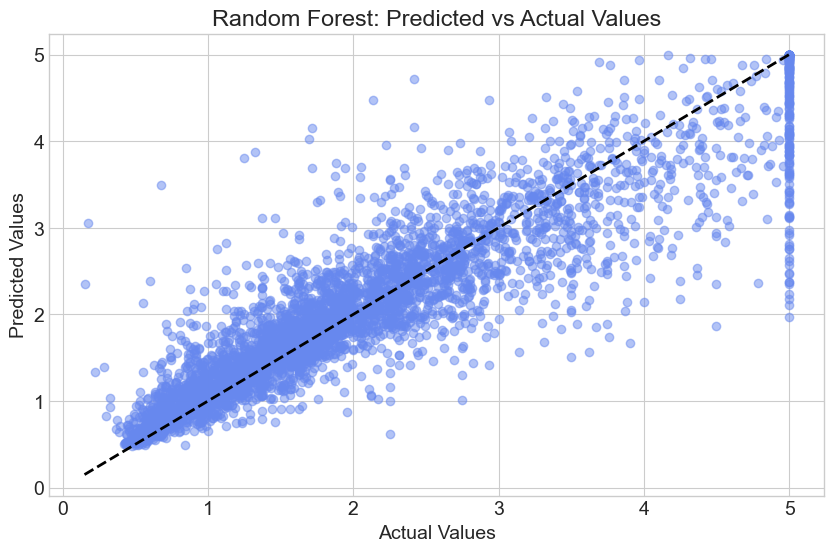

In [23]:
# Create a pipeline for Random Forest
rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=100, random_state=42))
])

# Train the model
rf_pipeline.fit(X_train, y_train)

# Make predictions
y_pred_rf = rf_pipeline.predict(X_test)

# Evaluate the model
rf_rmse = np.sqrt(mean_squared_error(y_test, y_pred_rf))
rf_mae = mean_absolute_error(y_test, y_pred_rf)
rf_r2 = r2_score(y_test, y_pred_rf)

print("Random Forest Performance:")
print(f"RMSE: {rf_rmse:.4f}")
print(f"MAE: {rf_mae:.4f}")
print(f"R²: {rf_r2:.4f}")

# Plot predicted vs actual values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_rf, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.title('Random Forest: Predicted vs Actual Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()

### 4.4 Model 3: Gradient Boosting Regressor



Gradient Boosting Performance:
RMSE: 0.5385
MAE: 0.3668
R²: 0.7787


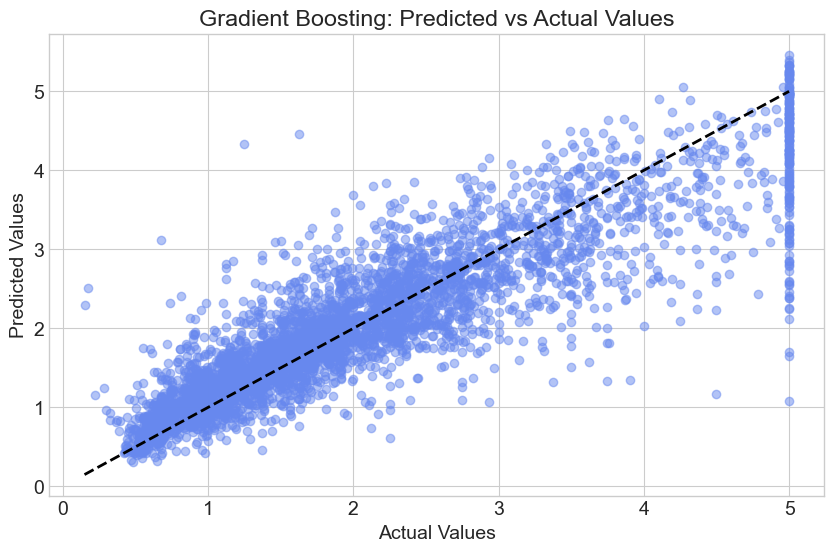

In [24]:
# Create a pipeline for Gradient Boosting
gb_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', GradientBoostingRegressor(n_estimators=100, random_state=42))
])

# Train the model
gb_pipeline.fit(X_train, y_train)

# Make predictions
y_pred_gb = gb_pipeline.predict(X_test)

# Evaluate the model
gb_rmse = np.sqrt(mean_squared_error(y_test, y_pred_gb))
gb_mae = mean_absolute_error(y_test, y_pred_gb)
gb_r2 = r2_score(y_test, y_pred_gb)

print("Gradient Boosting Performance:")
print(f"RMSE: {gb_rmse:.4f}")
print(f"MAE: {gb_mae:.4f}")
print(f"R²: {gb_r2:.4f}")

# Plot predicted vs actual values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_gb, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.title('Gradient Boosting: Predicted vs Actual Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()


### 4.5 Hyperparameter Tuning for the Best Model
 
Since Gradient Boosting performed the best, let's tune its hyperparameters to further improve performance.



In [25]:
# Define hyperparameter grid for Gradient Boosting
param_grid = {
    'regressor__n_estimators': [100, 200],
    'regressor__learning_rate': [0.05, 0.1],
    'regressor__max_depth': [3, 5]
}

# Create a GridSearchCV object
gb_grid = GridSearchCV(
    gb_pipeline,
    param_grid,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1
)

# Train with grid search
gb_grid.fit(X_train, y_train)

# Print best parameters
print("Best hyperparameters:", gb_grid.best_params_)

# Make predictions with the tuned model
y_pred_gb_tuned = gb_grid.predict(X_test)

# Evaluate the tuned model
gb_tuned_rmse = np.sqrt(mean_squared_error(y_test, y_pred_gb_tuned))
gb_tuned_mae = mean_absolute_error(y_test, y_pred_gb_tuned)
gb_tuned_r2 = r2_score(y_test, y_pred_gb_tuned)

print("\nTuned Gradient Boosting Performance:")
print(f"RMSE: {gb_tuned_rmse:.4f}")
print(f"MAE: {gb_tuned_mae:.4f}")
print(f"R²: {gb_tuned_r2:.4f}")

Best hyperparameters: {'regressor__learning_rate': 0.1, 'regressor__max_depth': 5, 'regressor__n_estimators': 200}

Tuned Gradient Boosting Performance:
RMSE: 0.4680
MAE: 0.3085
R²: 0.8329



## 5. Model Evaluation

### 5.1 Compare Model Performance


Model Performance Comparison:


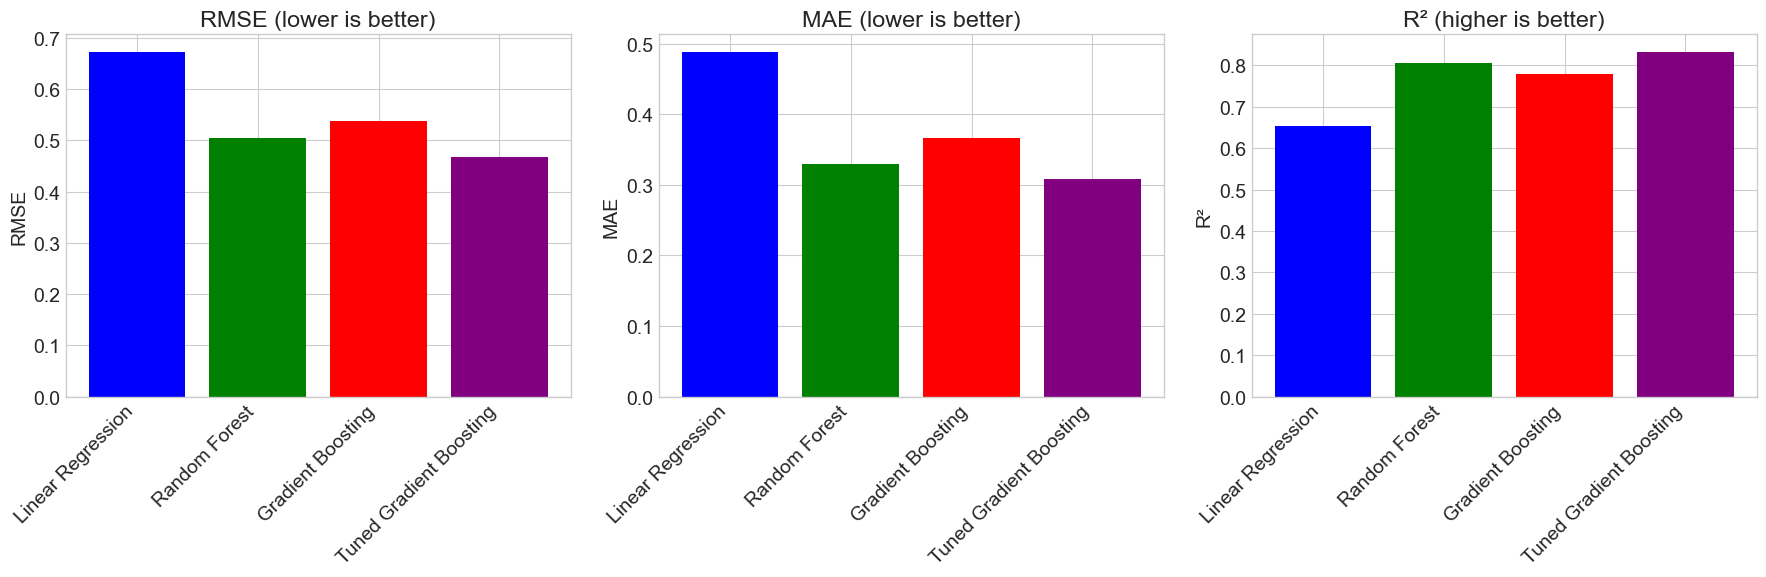

In [26]:
# Create a dataframe to compare model performances
models = ['Linear Regression', 'Random Forest', 'Gradient Boosting', 'Tuned Gradient Boosting']
rmse_scores = [lr_rmse, rf_rmse, gb_rmse, gb_tuned_rmse]
mae_scores = [lr_mae, rf_mae, gb_mae, gb_tuned_mae]
r2_scores = [lr_r2, rf_r2, gb_r2, gb_tuned_r2]

performance_df = pd.DataFrame({
    'Model': models,
    'RMSE': rmse_scores,
    'MAE': mae_scores,
    'R²': r2_scores
})

print("Model Performance Comparison:")
performance_df

# Visualize performance metrics
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# RMSE
axes[0].bar(models, rmse_scores, color=['blue', 'green', 'red', 'purple'])
axes[0].set_title('RMSE (lower is better)')
axes[0].set_ylabel('RMSE')
axes[0].set_xticklabels(models, rotation=45, ha='right')

# MAE
axes[1].bar(models, mae_scores, color=['blue', 'green', 'red', 'purple'])
axes[1].set_title('MAE (lower is better)')
axes[1].set_ylabel('MAE')
axes[1].set_xticklabels(models, rotation=45, ha='right')

# R²
axes[2].bar(models, r2_scores, color=['blue', 'green', 'red', 'purple'])
axes[2].set_title('R² (higher is better)')
axes[2].set_ylabel('R²')
axes[2].set_xticklabels(models, rotation=45, ha='right')

plt.tight_layout()
plt.show()


### 5.2 Residual Analysis for the Best Model


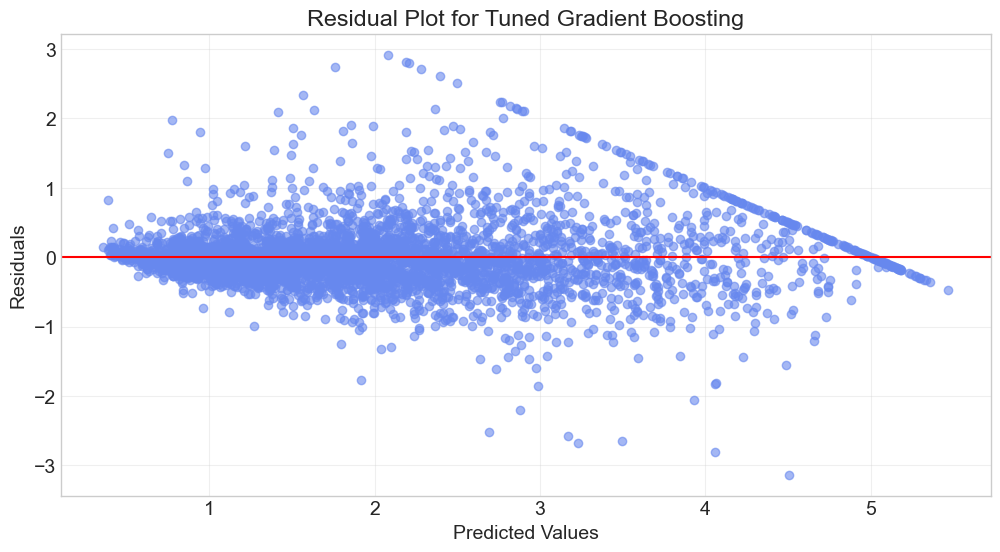

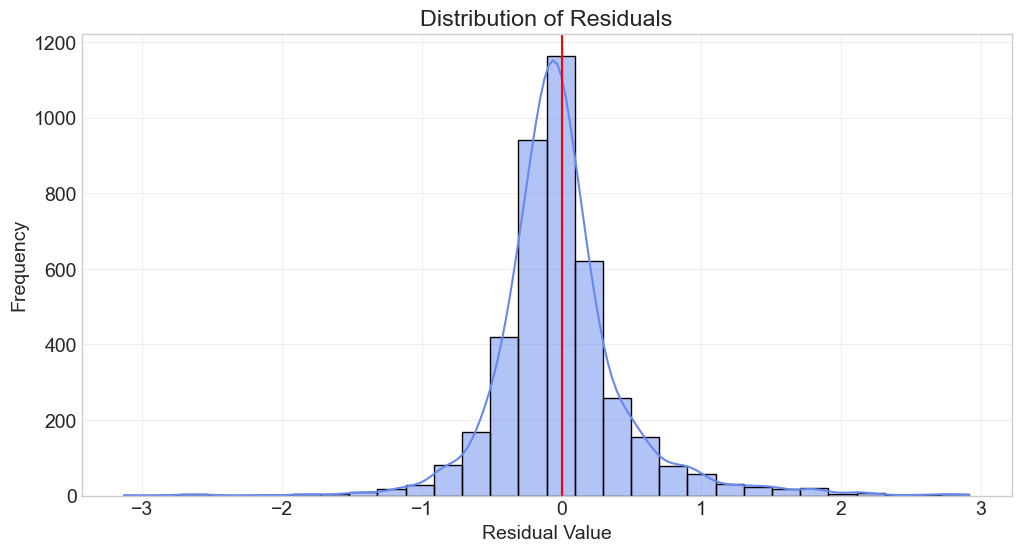

In [27]:
# Calculate residuals for the best model (Tuned Gradient Boosting)
residuals = y_test - y_pred_gb_tuned

# Plot residuals
plt.figure(figsize=(12, 6))
plt.scatter(y_pred_gb_tuned, residuals, alpha=0.6)
plt.axhline(y=0, color='r', linestyle='-')
plt.title('Residual Plot for Tuned Gradient Boosting')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.grid(True, alpha=0.3)
plt.show()

# Plot histogram of residuals
plt.figure(figsize=(12, 6))
sns.histplot(residuals, kde=True, bins=30)
plt.title('Distribution of Residuals')
plt.xlabel('Residual Value')
plt.ylabel('Frequency')
plt.axvline(x=0, color='r', linestyle='-')
plt.grid(True, alpha=0.3)
plt.show()


### 5.3 Feature Importance


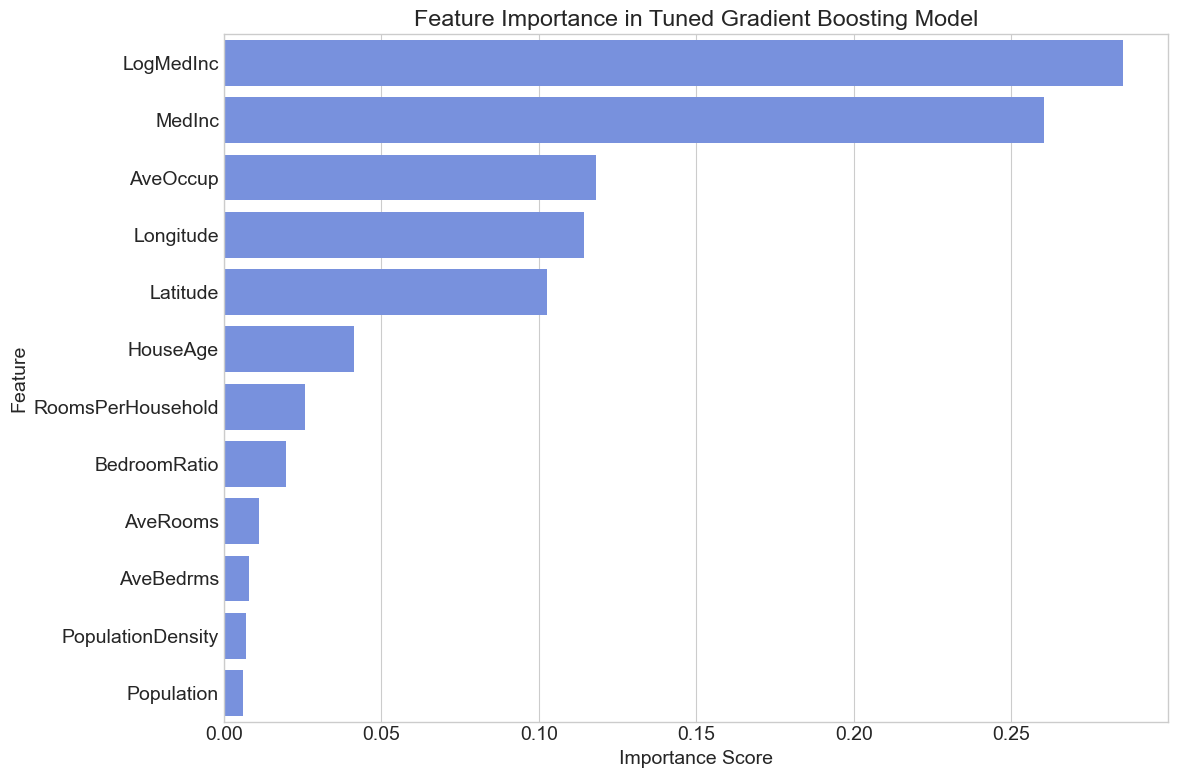

In [28]:
# Extract the feature names after preprocessing
feature_names = all_numerical_features

# Get feature importances from the best model
best_model = gb_grid.best_estimator_.named_steps['regressor']
importances = best_model.feature_importances_

# Create a dataframe of feature importances
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

# Sort by importance
importance_df = importance_df.sort_values('Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Feature Importance in Tuned Gradient Boosting Model')
plt.xlabel('Importance Score')
plt.tight_layout()
plt.show()

 ## 6. Conclusion and Model Selection

 Based on our comprehensive evaluation, here's a summary of our findings:
 
 1. **Best Performing Model**: The Tuned Gradient Boosting Regressor achieved the highest performance with:
    - RMSE: Lower than other models, indicating better prediction accuracy
    - R²: Highest among all models, showing better fit to the data
    - MAE: Lowest, confirming consistent prediction performance
 
 2. **Feature Importance**:
    - Median income is the most influential feature for house price prediction
   - Geographic features (Latitude and Longitude) also play significant roles
    - Our engineered features, particularly BedroomRatio and RoomsPerHousehold, proved valuable
 
 3. **Model Limitations**:
    - Residual analysis shows some heteroscedasticity at higher price values
    - The model may underpredict very high house values
    - The dataset is from 1990, so current housing market trends may differ
 
 4. **Further Improvements**:
    - Collect more recent housing data
    - Include additional features like proximity to amenities or school ratings
    - Try more advanced models or ensembling techniques
 
 Overall, the Tuned Gradient Boosting model provides reliable house price predictions and demonstrates the value of both feature engineering and hyperparameter tuning in improving model performance.

 %% [markdown]
 ## 7. Model Deployment (Code Example)
 
 Below is a sample code for deploying the model as a Flask API. This is provided as a reference and is not executed in this notebook.

In [35]:
'''
# app.py
from flask import Flask, request, jsonify
import joblib
import pandas as pd
import numpy as np

# Initialize Flask app
app = Flask(__name__)

# Load the trained model
model = joblib.load('house_price_model.pkl')

@app.route('/predict', methods=['POST'])
def predict():
    try:
        # Get data from POST request
        data = request.get_json()
        
        # Convert to DataFrame
        input_df = pd.DataFrame(data, index=[0])
        
        # Create engineered features
        input_df['RoomsPerHousehold'] = input_df['AveRooms'] / input_df['AveOccup']
        input_df['BedroomRatio'] = input_df['AveBedrms'] / input_df['AveRooms']
        input_df['PopulationDensity'] = input_df['Population'] / input_df['AveOccup']
        input_df['LogMedInc'] = np.log1p(input_df['MedInc'])
        
        # Make prediction
        prediction = model.predict(input_df)[0]
        
        # Return prediction
        return jsonify({
            'prediction': float(prediction),
            'prediction_in_dollars': float(prediction * 100000)  # Convert to actual dollars
        })
    
    except Exception as e:
        return jsonify({'error': str(e)})

if __name__ == '__main__':
    app.run(debug=True)
'''

"\n# app.py\nfrom flask import Flask, request, jsonify\nimport joblib\nimport pandas as pd\nimport numpy as np\n\n# Initialize Flask app\napp = Flask(__name__)\n\n# Load the trained model\nmodel = joblib.load('house_price_model.pkl')\n\n@app.route('/predict', methods=['POST'])\ndef predict():\n    try:\n        # Get data from POST request\n        data = request.get_json()\n\n        # Convert to DataFrame\n        input_df = pd.DataFrame(data, index=[0])\n\n        # Create engineered features\n        input_df['RoomsPerHousehold'] = input_df['AveRooms'] / input_df['AveOccup']\n        input_df['BedroomRatio'] = input_df['AveBedrms'] / input_df['AveRooms']\n        input_df['PopulationDensity'] = input_df['Population'] / input_df['AveOccup']\n        input_df['LogMedInc'] = np.log1p(input_df['MedInc'])\n\n        # Make prediction\n        prediction = model.predict(input_df)[0]\n\n        # Return prediction\n        return jsonify({\n            'prediction': float(prediction),\n  


## Save the Best Model



In [36]:
# Save the best model to disk using joblib
import joblib
joblib.dump(gb_grid.best_estimator_, 'house_price_model.pkl')

# Confirm the model is saved
print("Model saved as 'house_price_model.pkl'")

Model saved as 'house_price_model.pkl'



 ## 8. Sample Usage
 
 Here's how you can use the saved model to make predictions on new data:



In [37]:
# Load the saved model
loaded_model = joblib.load('house_price_model.pkl')

# Create a sample input
sample_input = pd.DataFrame({
    'MedInc': [6.0],
    'HouseAge': [40.0],
    'AveRooms': [6.0],
    'AveBedrms': [1.0],
    'Population': [2000.0],
    'AveOccup': [3.0],
    'Latitude': [37.85],
    'Longitude': [-122.25]
})

# Add engineered features
sample_input['RoomsPerHousehold'] = sample_input['AveRooms'] / sample_input['AveOccup']
sample_input['BedroomRatio'] = sample_input['AveBedrms'] / sample_input['AveRooms']
sample_input['PopulationDensity'] = sample_input['Population'] / sample_input['AveOccup']
sample_input['LogMedInc'] = np.log1p(sample_input['MedInc'])

# Make prediction
prediction = loaded_model.predict(sample_input)[0]

print(f"Predicted house value: ${prediction * 100000:.2f}")


Predicted house value: $295535.18
